In [1]:
import lifemodels as lms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

os.chdir("/Users/user/Work/lifemodels/examples")

![alt text](http://a.fsdn.com/allura/p/deday/icon "")  `lifemodels`
=======

What is it?
-----------

**lifemodels** is a Python package for fitting lifespan data to a number of models using MLE.  It also implements GLM (generalized linear model) for those lifespan distributions.

**deday** stands for *Demography Data Analyses*.  The older versions can be found [here](http://sourceforge.net/projects/deday/).

**[Read the minimal example](http://nbviewer.ipython.org/github/ctzhu/lifemodels/blob/master/examples/Intro_example.ipynb)** for a simple workflow in `IPython Notebook` 

Where to find support?
-------------

[**Read the documentation**](https://github.com/ctzhu/lifemodels/blob/master/doc/Guide.txt) for instructions.

If you use deday for published research, please contact me as `lifemodels` has not yet been published.
To install, run `pip install git+https://github.com/ctzhu/lifemodels`

## • Time-to-event data
• Engineering: Reliability (MTTF)

• Marketing: Attribution (web cookie expiration, time-dependent binary responce)

• Biomedical science: lifespan, survivorship.

## • Censor and missing data
• Event time is $[T0, T1)$

• T0==T1, or only know T0, or only know T1, ...

## • Time-dependent and Time-independent components:
• Benjamin Gompertz & William Makeham.

• [Gompertz Makeham law of mortality](https://en.wikipedia.org/wiki/Gompertz%E2%80%93Makeham_law_of_mortality):
$H(t)=\alpha e^{\beta t} + C$

• Example: Estimated probability of a person dying at each age, for the U.S. in 2003

<table>
  <tr>
    <th> <img src="https://upload.wikimedia.org/wikipedia/commons/a/a9/Gompertz.png" alt="Gompertz" height="200" width="200"> </th>
    <th> <img src="https://s3.amazonaws.com/nodeimages/87605343/images/87605343_0_nocrop.jpg" alt="Makeham" height="200" width="200"> </th>
    <th> <img src="https://upload.wikimedia.org/wikipedia/en/4/4d/USGompertzCurve.svg" alt="Makeham" height="300" width="300"> </th>
  </tr>
</table>

## *Basic usage*
##  · Read the data and create a survival object using `.survt_df()` method
### · Data taken from Clive McCay *et.al* :

*The effect of retarded growth upon the length of life span and upon the ultimate body size. J Nutr. 1935;10:63–79*

### · Credited with the discovery of dietray restriction (Eat less live longer)
### · Two treatments: `Diet` and `Sex`. `III` type diet being the richest.
### · Death events of rat recorded over ~1500 days.

In [2]:
df   = pd.read_csv('mckay.txt', sep=' ')
df['Time1'] = df.Time0 
#Time-to-event data, Time0 is the left bound, Time1 is the right bound.
s_df = lms.s_models.survt_df(df)
df.head()

,Diet,Sex,Time0,Time1
0,II,Male,41,41
1,II,Female,48,48
2,II,Female,62,62
3,I,Male,71,71
4,I,Female,74,74


## · Specify the model and create the model fit object using `.distfit_df()` method

In [3]:
gp2_model = lms.s_models.distfit_df(s_df, 'gp2')
gp3_model = lms.s_models.distfit_df(s_df, 'gp3')
wb2_model = lms.s_models.distfit_df(s_df, 'wb2')
wb3_model = lms.s_models.distfit_df(s_df, 'wb3')
gl4_model = lms.s_models.distfit_df(s_df, 'gl4')

## · Hazard functions of 5 models in this example are:

$H(t)=C$

Exponential Decay

---

$H(t)=(\kappa/\lambda)\cdot(t/\lambda)^{\kappa-1}$

$log(H(t))=log(\kappa \cdot \lambda^{-\kappa})+(\kappa-1)\cdot log(x)$

Weibull model (Mortality increase with time in a power function relationship) `'wb2'`

---

$H(t)=\alpha e^{\beta t}$

$log(H(t))=log(\alpha)+ \beta t $

Gompertz model (Mortality increase with time Exponentially) `'gp2'`

---

$H(t)=\alpha e^{\beta t} - \alpha + C$

Gompertz-Makehamm model `'gp3'`

---

$H(t)=(\kappa/\lambda)\cdot(t/\lambda)^{\kappa-1} + C$

Weibull-Makehamm model `'wb3'`

---

$H(t)=\frac{\alpha e^{\beta t}}{d e^{\beta t} + 1} - \frac{\alpha}{d+1} + C$

Gompertz-logistic model `'gl4'`

## · MLE parameter estimates

In [4]:
gp3_model.mdl_all_free

alpha      beta          c        logL  optimizer_flag
Diet Sex                                                               
I    Female -10.092006 -5.256360  -9.161662  150.595193               0
     Male    -7.456580 -5.600244  -8.244084   94.532260               0
II   Female -12.035084 -5.164614  -7.347579  166.641636               0
     Male   -11.646710 -5.201537  -7.604894   93.726082               0
III  Female  -9.134449 -5.600461  -8.840873  134.671557               0
     Male    -9.521764 -5.493469 -34.652509  103.225741               0

In [5]:
gp3_model.mdl_all_cnst

array([  -9.13151133,   -5.6333212 ,   -8.08416424,  760.39933924,    0.        ])

## · Variance of the parameter estimates

It might not always be there, due to float overflow and underflow problems

In [6]:
gp3_model.var

alpha      beta         c
Diet Sex                                 
I    Female  1.128514  0.239391  1.227479
     Male    1.531880  0.588591  1.769442
II   Female  2.126095  0.317832  0.375416
     Male    3.082429  0.486870  0.654951
III  Female  1.616147  0.429353  1.752450
     Male         NaN       NaN       inf

## · log quantile function (time-to-reach-%-of-death estimate):  `.logq()` method

.`logq(key, q)`, `key` is genotype-food combination here. `q` is that target % of death, default to 50%, therefore by default it returns the estimate for medium lifespan.

.`logq()` method and `.logq_nc()` method are similar: the latter ignores the Makehamm term ($C$), if there is one.

In [7]:
(gp3_model.logq(('I', 'Female')), gp3_model.logq_nc(('I', 'Female')))

(6.7381684156777482, 6.7561002844234102)

In [8]:
medium_df = pd.DataFrame({'With_C'   : map(gp3_model.logq,    gp3_model.mdl_all_free.index),
                          'Without_C': map(gp3_model.logq_nc, gp3_model.mdl_all_free.index)},
                         index=gp3_model.mdl_all_free.index)
np.exp(medium_df)

With_C    Without_C
Diet Sex                            
I    Female  844.013438   859.284688
     Male    504.323750   457.970938
II   Female  862.616125  1138.258375
     Male    915.955188  1104.003063
III  Female  856.054813   868.123188
     Male    918.315313   896.341313

## · Get the estimated log mean lifespan using `.logm()` method 

In [9]:
(gp3_model.logm(('I', 'Female')), gp3_model.logm_nc(('I', 'Female')))

(6.6869775131919171, 6.7150616442887863)

## · ... and the $\sigma^2$ for calculating the confidence interval for survival time using `.logt_var()`

In [10]:
gp3_model.logt_var(('I', 'Female'), 6.6869775131919171)

0.0018048249213575979

## · Plot harzard plot, survival plot and other plots using `.plot()` method

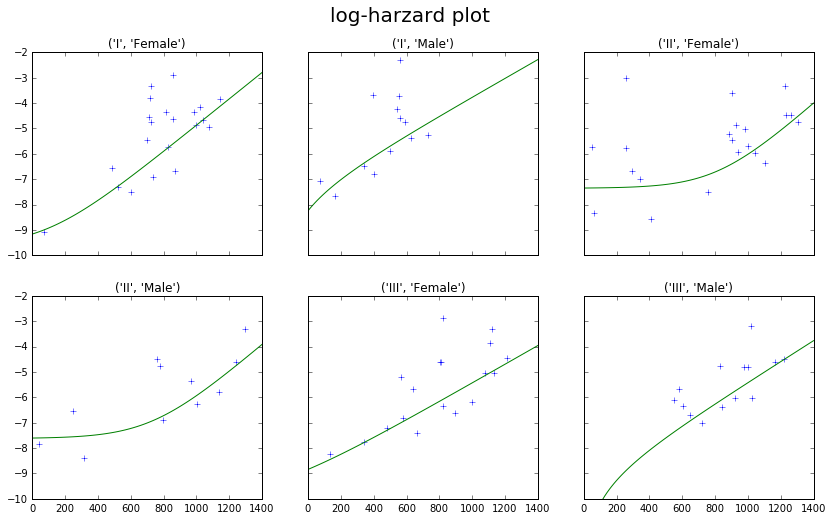

In [11]:
f, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()
for ax, key in zip(axes, gp3_model.mdl_all_free.index.tolist()):
    gp3_model.plot(key, np.linspace(0,1400,100),ax,'hzd')
    ax.set_ylim((-10,-2))
    ax.set_title(key)
plt.suptitle('log-harzard plot', fontsize=20)

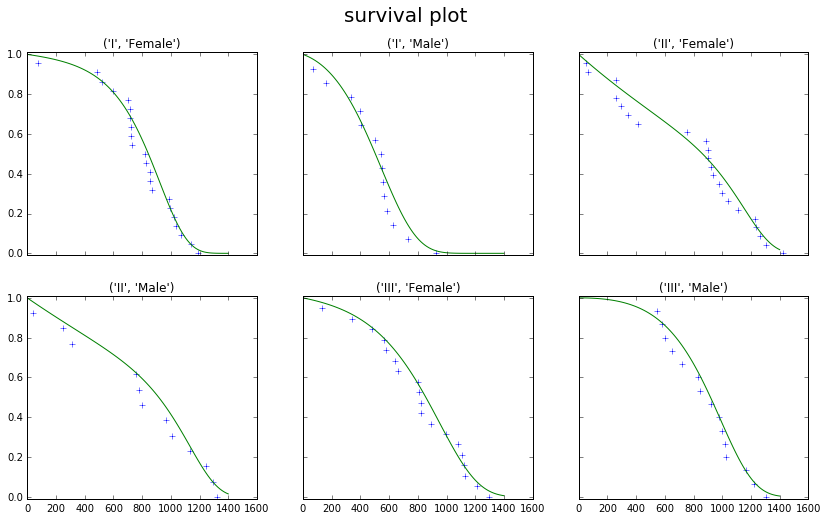

In [12]:
f, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()
for ax, key in zip(axes, gp3_model.mdl_all_free.index.tolist()):
    gp3_model.plot(key, np.linspace(0,1400,100),ax,'sf')
    ax.set_ylim((-0.01,1.01))
    ax.set_title(key)
plt.suptitle('survival plot', fontsize=20)

## · Plot multidimensional confidence regions with  `.contourf_2D()` method
### · *AKA. Why Gompertz distribution is rarely worked on*.

### · Weibull model is a well-conditionned quadratic function

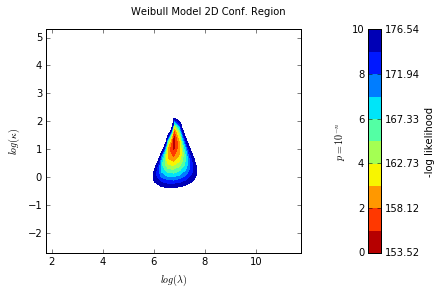

In [13]:
f, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[20,1], 'wspace': 0.5})
wb2_model.contourf_2D(('I','Female'),
                       ax, cax,
                      (np.linspace(-5, 5, 41),
                       np.linspace(-4, 4, 45)))
plt.suptitle('Weibull Model 2D Conf. Region')

### · Gompertz model is an ill-conditionned very non-quadratic function.

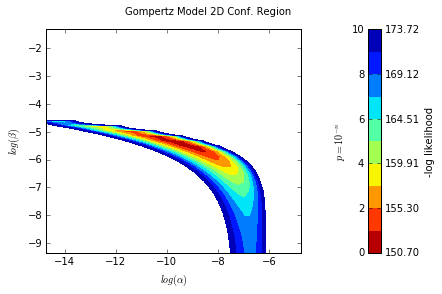

In [14]:
f, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[20,1], 'wspace': 0.5})
gp2_model.contourf_2D(('I','Female'),
                       ax, cax,
                      (np.linspace(-5, 5, 41),
                       np.linspace(-4, 4, 45)))
plt.suptitle('Gompertz Model 2D Conf. Region')

### · Challenge of Gompertz model: precision lost due to overflow/underflow.

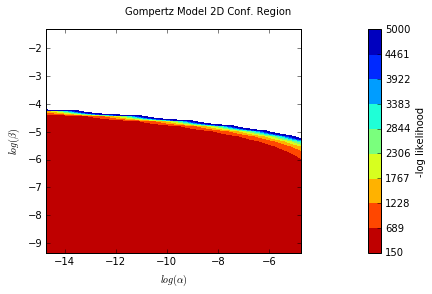

In [15]:
f, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[20,1], 'wspace': 0.5})
gp2_model.contourf_2D(('I','Female'),
                       ax, cax,
                      (np.linspace(-5, 5, 41),
                       np.linspace(-4, 4, 45)),
                      levels=np.linspace(150,5000,10))
plt.suptitle('Gompertz Model 2D Conf. Region')

### · Gompertz-Makeham model: multidimensional optimization problem is even harder

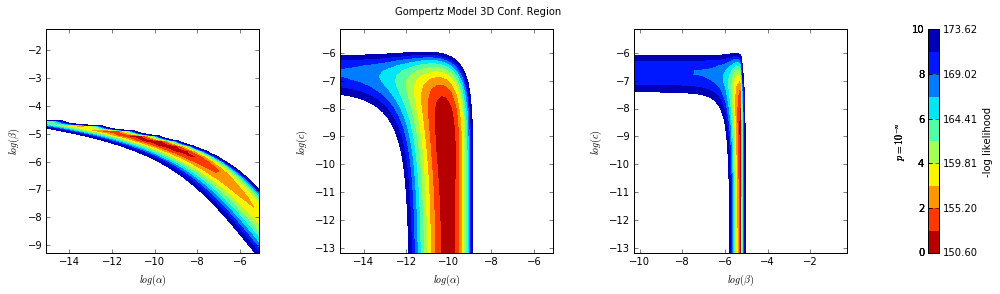

In [16]:
f, (ax1, ax2, ax3, cax) = plt.subplots(1, 4, 
                                       gridspec_kw={'width_ratios':[20,20,20,1], 'wspace': 0.5}, 
                                       figsize=(16,4))

gp3_model.contourf_2D(('I','Female'),
                      ax1, cax,
                      (np.linspace(-5, 5, 41),
                       np.linspace(-4, 4, 45),
                       np.linspace(0,0,1)))
gp3_model.contourf_2D(('I','Female'),
                      ax2, cax,
                      (np.linspace(-5, 5, 41),
                       np.linspace(0,0,1),
                       np.linspace(-4, 4, 45)))
gp3_model.contourf_2D(('I','Female'),
                      ax3, cax,
                      (np.linspace(0,0,1),
                       np.linspace(-5, 5, 41),
                       np.linspace(-4, 4, 45)))
plt.suptitle('Gompertz Model 3D Conf. Region')

# *Experimental Functionality*

## · GLM (generalized linear models) for scale, shape, location, $\alpha$, $\beta$, $\kappa$, $\lambda$... (you name it)
## · ... and partially fixed models too.

In [17]:
wb2_glm = lms.s_models.model(wb2_model)

## · With Weibull $\lambda$ fixed, it is a form of parametric proportional hazard model

In [18]:
wb2_glm.fit_partial_model('Diet*Sex', [0])

full model
763.455156875
1 + Diet + Sex + Diet:Sex


Estimate     Error    Std_Estm             p  \
lambda FIXED                    6.798327  0.038464  176.744239  0.000000e+00   
kappa  Intercept                1.305685  0.176284    7.406721  1.294604e-13   
       Diet[T.II]              -0.741023  0.250665   -2.956224  3.114305e-03   
       Diet[T.III]             -0.224766  0.253053   -0.888219  3.744232e-01   
       Sex[T.Male]             -0.752211  0.300749   -2.501121  1.238009e-02   
       Diet[T.II]:Sex[T.Male]   0.860879  0.424572    2.027641  4.259694e-02   
       Diet[T.III]:Sex[T.Male]  0.994089  0.401105    2.478376  1.319818e-02   

                               sig_code  
lambda FIXED                        ***  
kappa  Intercept                    ***  
       Diet[T.II]                    **  
       Diet[T.III]                       
       Sex[T.Male]                    *  
       Diet[T.II]:Sex[T.Male]         *  
       Diet[T.III]:Sex[T.Male]        *

## · With Weibull $\kappa$ fixed, it is a from of ALT (Accelerated life testing) or parametric survival regression model

## · `R` does it too, let's compare the solutions

In [19]:
wb2_glm.fit_partial_model('Diet*Sex', [1])

full model
764.764241985
1 + Diet + Sex + Diet:Sex


Estimate     Error   Std_Estm             p  \
lambda Intercept                6.751581  0.082636  81.703078  0.000000e+00   
       Diet[T.II]               0.077556  0.115595   0.670935  5.022621e-01   
       Diet[T.III]              0.046200  0.120943   0.382001  7.024608e-01   
       Sex[T.Male]             -0.424428  0.132148  -3.211772  1.319189e-03   
       Diet[T.II]:Sex[T.Male]   0.445991  0.188387   2.367423  1.791244e-02   
       Diet[T.III]:Sex[T.Male]  0.472587  0.187643   2.518538  1.178431e-02   
kappa  FIXED                    0.950563  0.083379  11.400464  4.158974e-30   

                               sig_code  
lambda Intercept                    ***  
       Diet[T.II]                        
       Diet[T.III]                       
       Sex[T.Male]                   **  
       Diet[T.II]:Sex[T.Male]         *  
       Diet[T.III]:Sex[T.Male]        *  
kappa  FIXED                        ***

### *R results:*

```R
> S1 <- survreg(Surv(Time0) ~ Diet*Sex, dist='weibull', data=df)
> summary(S1)
```

    Call:
    survreg(formula = Surv(Time0) ~ Diet * Sex, data = df, dist = "weibull")
                      Value Std. Error       z        p
    (Intercept)      6.7515     0.0827  81.680 0.00e+00
    DietII           0.0776     0.1156   0.671 5.02e-01
    DietIII          0.0462     0.1211   0.382 7.03e-01
    SexMale         -0.4243     0.1323  -3.208 1.34e-03
    DietII:SexMale   0.4459     0.1885   2.366 1.80e-02
    DietIII:SexMale  0.4725     0.1881   2.512 1.20e-02
    Log(scale)      -0.9506     0.0834 -11.393 4.56e-30

    Scale= 0.387 

    Weibull distribution
    Loglik(model)= -764.8   Loglik(intercept only)= -771.7
        Chisq= 13.89 on 5 degrees of freedom, p= 0.016 
    Number of Newton-Raphson Iterations: 7 
    n= 106 

## · Model both $\lambda$ and $\kappa$
## · It is an inference problem, biologists like to assign parameters with biological meanings and like to know if any treatment specifically affects one type of biological process *but* not the others.

In [20]:
wb2_glm.fit_partial_model('Diet*Sex', [])

full model
756.811302667
1 + Diet + Sex + Diet:Sex


Estimate     Error    Std_Estm             p  \
lambda Intercept                6.779874  0.060458  112.142038  0.000000e+00   
       Diet[T.II]              -0.024163  0.139007   -0.173825  8.620029e-01   
       Diet[T.III]              0.034694  0.100518    0.345149  7.299825e-01   
       Sex[T.Male]             -0.457921  0.127040   -3.604546  3.126989e-04   
       Diet[T.II]:Sex[T.Male]   0.513089  0.230077    2.230075  2.574248e-02   
       Diet[T.III]:Sex[T.Male]  0.534661  0.162749    3.285178  1.019179e-03   
kappa  Intercept                1.294548  0.177237    7.304042  2.792497e-13   
       Diet[T.II]              -0.743416  0.254887   -2.916650  3.538121e-03   
       Diet[T.III]             -0.201293  0.260995   -0.771254  4.405566e-01   
       Sex[T.Male]             -0.380653  0.282381   -1.348009  1.776556e-01   
       Diet[T.II]:Sex[T.Male]   0.508561  0.416936    1.219757  2.225571e-01   
       Diet[T.III]:Sex[T.Male]  0.761791  0.397472    1.916591  5.528997e-02   

                               sig_code  
lambda Intercept                    ***  
       Diet[T.II]                        
       Diet[T.III]                       
       Sex[T.Male]                  ***  
       Diet[T.II]:Sex[T.Male]         *  
       Diet[T.III]:Sex[T.Male]       **  
kappa  Intercept                    ***  
       Diet[T.II]                    **  
       Diet[T.III]                       
       Sex[T.Male]                       
       Diet[T.II]:Sex[T.Male]            
       Diet[T.III]:Sex[T.Male]        +

# Notes on Implementation:

## · log-likelihood calculation is costy
## · ... and I want to handle interval censored, right censored, mix censored, etc in one shot
## · ... and in some cases I want to avoid precision lost
## · Let's do it in `FORTRAN`

`mortdist.f90`

```FORTRAN
            subroutine lg3LLK(sx1, sx2, sy, su, ss, sc, n)
            double precision, intent(in) :: sx1(n), sx2(n)
            double precision, intent(out) :: sy
            double precision :: su, ss, sc
            integer n, i

            real(kind=10) :: x1(n), x2(n)
            real(kind=10) :: y
            real(kind=10) :: v1, v2, u, s, c

            x1= sx1
            x2= sx2
            u = su
            s = ss
            c = sc
            y = 0.0_10

            do 100 i=1, n
                v1 = exp((u-x1(i))/s)
                if (x1(i) == x2(i)) then
                    y = y+log(v1)-log(1.0_10+v1) &
                         -c*x1(i) &
                         +log(1.0_10/s/(1.0_10+v1)+c)
                else
                    v2 = exp((u-x2(i))/s)
                    y = y+log(v1/(1.0_10+v1)/exp(c*x1(i)) &
                             -v2/(1.0_10+v2)/exp(c*x2(i)))
                end if
    100     continue
            sy = dble(y)
            end subroutine lg3LLK
```

## · Grid-search (to get initial guess) is costy, calculating derivative is costy
## · `scipy.stats` build-in continuous distributions are slow
## · Do them in `FORTRAN` as well

Getting CDF, PDF, SF, and H from one call to avoid calculate the same thing more than once. 

`mortdist_cpsh.f90` 
```FORTRAN
            subroutine gp2_cpsh(p, x, cdf, pdf, sf, hzd, m, n)
            double precision, intent(in) :: p(m), x(n)
            double precision, intent(out):: cdf(n), pdf(n), sf(n), hzd(n)
            double precision :: a, b
            double precision :: ebx(n)
            integer :: m, n
            a = p(1)
            b = p(2)
            ebx = exp(b*x)
            hzd = a*ebx
            sf  = exp(-a/b*(ebx-1.0d0))
            pdf = hzd*sf
            cdf = 1.0d0-sf
            end subroutine gp2_cpsh
```